# Programming with InfluxDB

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd

### 1. First, we install the InfluxDB Client Library.

In [2]:
#!pip3 install influxdb-client

### 2. Then, we set up the connection.

In [3]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

In [4]:
import random
from datetime import datetime, timezone, timedelta
import pytz
local_tz = pytz.timezone('Europe/Berlin')

In [5]:
token = os.environ.get("INFLUXDB_TOKEN")
org = "DS_FH_Kiel"
url = "http://localhost:8086"

client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)

### 3. Now, we can test the database connection by accessing the previously created bucket.

In [6]:
bucket = "BDT"

try:
    write_api = client.write_api(write_options=SYNCHRONOUS)

    for value in range(5):
        current_time = datetime.now(timezone.utc).strftime('%Y-%m-%dT%H:%M:%SZ')
        
        point =  ( Point("measurement1")
            .tag("tagname1", "tagvalue1")
            .field("field1", value)
            .time(current_time, WritePrecision.NS)
        )
        write_api.write(bucket=bucket, org=org, record=point)
        time.sleep(1)  # separate points by 1 second
    
    print("Data written successfully to bucket 'BDT'.")

except Exception as e:
    print(f"An error occurred: {e}")


Data written successfully to bucket 'BDT'.


The data was inserted successfully, meaning the connection was established.

### 4. Then, we create 300 random measurements (1 per second) of temperature as time series data to demonstrate data writing. For this, we use the random library.

In [7]:
def generate_random_data():
    return random.uniform(16.0, 17.0) 

In [8]:
def create_data_points(num_points):
    data_points = []
    for _ in range(num_points):
        temperature = generate_random_data()
        
        current_time = datetime.now(timezone.utc).strftime('%Y-%m-%dT%H:%M:%SZ')
        
        point = Point("weather")\
            .tag("location", "office")\
            .field("temperature", temperature)\
            .time(current_time, WritePrecision.NS)
        
        data_points.append(point)
        time.sleep(1)
    
    return data_points


In [9]:
data_points = create_data_points(300)
write_api.write(bucket=bucket, record=data_points)

### 5. We can further explore the data by extracting and displaying the time series data.

In [10]:
query_api = client.query_api()

A general rule with InfluxDB is that all timestamps are stored internally in UTC format, regardless of the timezone of the input data. When queried, timestamps are returned in UTC format, often indicated by the +00:00 suffix or Z notation. It is important to convert these UTC timestamps to the local timezone when reading the data to ensure it accurately reflects the local time context.

In [11]:
def query_data(query_api, org, query):
    result = query_api.query(org=org, query=query)
    return result

def convert_to_dataframe(result):
    data = []
    for table in result:
        for record in table.records:
            local_time = record.get_time().astimezone(local_tz)
            data.append((local_time, record.get_value()))

    df = pd.DataFrame(data, columns=['Time', 'Temperature'])
    return df

def print_data_points(result):
    for table in result:
        for record in table.records:
            local_time = record.get_time().astimezone(local_tz)
            print(f"Time: {local_time}, Measurement: {record.get_measurement()}, Field: {record.get_field()}, Value: {record.get_value()}")

def plot_line_chart(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time'], df['Temperature'], marker='o')
    plt.title("Temperature Over Time")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### 5.1. Query data

In [12]:
# Query all data points 

query = """
from(bucket: "BDT")
  |> range(start: 0, stop: now())
"""

result = query_data(query_api, org=org, query=query)
print_data_points(result)

Time: 2025-05-16 13:56:20+02:00, Measurement: measurement1, Field: field1, Value: 0
Time: 2025-05-16 13:56:21+02:00, Measurement: measurement1, Field: field1, Value: 1
Time: 2025-05-16 13:56:22+02:00, Measurement: measurement1, Field: field1, Value: 2
Time: 2025-05-16 13:56:23+02:00, Measurement: measurement1, Field: field1, Value: 3
Time: 2025-05-16 13:56:24+02:00, Measurement: measurement1, Field: field1, Value: 4
Time: 2025-05-16 13:56:42+02:00, Measurement: measurement1, Field: field1, Value: 0
Time: 2025-05-16 13:56:43+02:00, Measurement: measurement1, Field: field1, Value: 1
Time: 2025-05-16 13:56:44+02:00, Measurement: measurement1, Field: field1, Value: 2
Time: 2025-05-16 13:56:45+02:00, Measurement: measurement1, Field: field1, Value: 3
Time: 2025-05-16 13:56:46+02:00, Measurement: measurement1, Field: field1, Value: 4
Time: 2025-05-16 13:56:48+02:00, Measurement: weather, Field: temperature, Value: 16.98161790677286
Time: 2025-05-16 13:56:49+02:00, Measurement: weather, Field

We didn't delete the testing data entries, which is why they are still present.

In [13]:
# Query temperature data from the last 2 minutes

query = f'''
    from(bucket: "{bucket}")
      |> range(start: -2m)
      |> filter(fn: (r) => r._measurement == "weather" and r._field == "temperature")
    '''

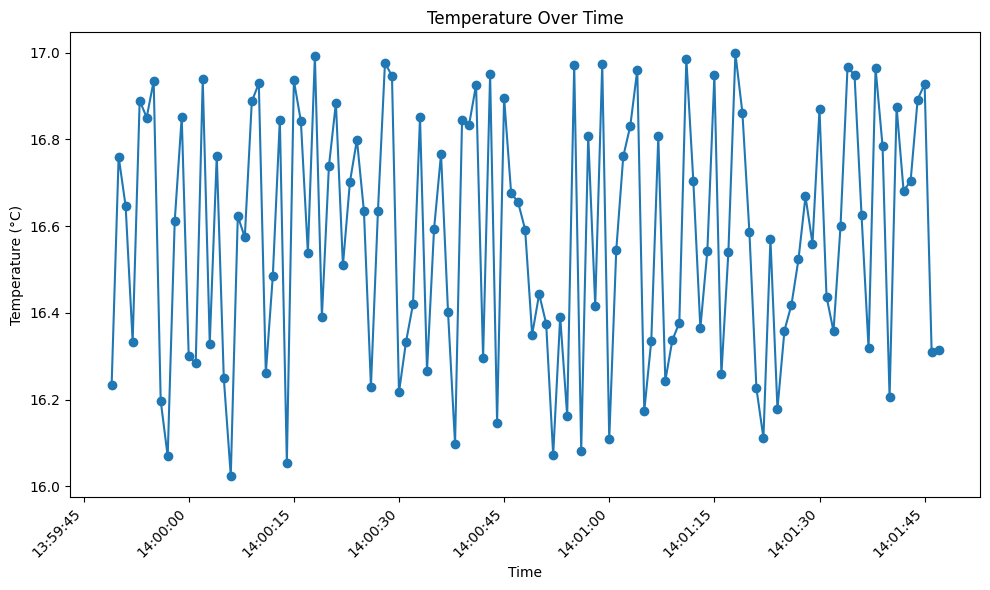

In [14]:
result = query_data(query_api, org=org, query=query)
df = convert_to_dataframe(result)

plot_line_chart(df)


#### 5.2. Delete data

In [15]:
delete_api = client.delete_api()
start = "2025-05-01T00:00:00Z"
stop = datetime.now(timezone.utc).strftime('%Y-%m-%dT%H:%M:%SZ')

predicate = ""  # Empty predicate to delete all data matching the time range

delete_api.delete(start, stop, predicate, bucket=bucket, org=org)